# Cluster Analysis

The goal of this notebook is to identify clusters of trip and customer types based on the bike rental demand patterns, as well as identifying clusters for the station locations.<br>
Therefore we made three analysis: clustering with the bike-trip-dataframe, taking the weather-dataframe into account, clustering the stations based on their demand.

## 1 Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from ast import literal_eval as make_tuple
import folium
from folium import plugins
from folium.plugins import HeatMap
from math import sin, cos, pi
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# edited trip dataframe 
df = pd.read_csv('../../dataset/chicago_2018_clean.csv')
df["start_time"] = pd.to_datetime(df['start_time'])
df["end_time"] = pd.to_datetime(df['end_time'] ) 
df["duration_per_trip"] = pd.to_timedelta(df.duration_per_trip)
df.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
0,2018-04-01 00:04:44,2018-04-01 00:13:03,22,171,May St & Taylor St,May St & Cullerton St,3819,Subscriber,0 days 00:08:19,0.138611
1,2018-04-01 00:06:42,2018-04-01 00:27:07,157,190,Lake Shore Dr & Wellington Ave,Southport Ave & Wrightwood Ave,5000,Subscriber,0 days 00:20:25,0.340278
2,2018-04-01 00:07:19,2018-04-01 00:23:19,106,106,State St & Pearson St,State St & Pearson St,5165,Customer,0 days 00:16:00,0.266667
3,2018-04-01 00:07:33,2018-04-01 00:14:47,241,171,Morgan St & Polk St,May St & Cullerton St,3851,Subscriber,0 days 00:07:14,0.120556
4,2018-04-01 00:10:23,2018-04-01 00:22:12,228,219,Damen Ave & Melrose Ave,Damen Ave & Cortland St,5065,Subscriber,0 days 00:11:49,0.196944


In [3]:
# edited weather dataframe 
weather=pd.read_csv('../../dataset/chicago_weather_2018.csv')
weather["date_time"] = pd.to_datetime(weather['date_time'])
weather.head()

,date_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0


In [4]:
# edited stations dataframe 
stations=pd.read_csv('../../dataset/chicago_stations.csv')
stations = stations.set_index("ID")
stations.head()

,station_name,x,y,position
ID,,,,
2,Buckingham Fountain,41.876423,-87.620339,"(41.876423, -87.620339)"
3,Shedd Aquarium,41.867226,-87.615355,"(41.86722595682, -87.6153553902)"
4,Burnham Harbor,41.857412,-87.613792,"(41.85741178707404, -87.61379152536392)"
5,State St & Harrison St,41.874053,-87.627716,"(41.874053, -87.627716)"
6,Dusable Harbor,41.886976,-87.612813,"(41.886976, -87.612813)"


## 2 Data Preparation

### 2.1 Preparation for Trip Clustering

For the first analysis we want to find clusters for trips and user types. We use the following **features of every trip**: <br>
* duration (trip_time_in_hours)
* user type 
* hour
* day of week
<br>
<br>


We do not include the station IDs and names since they do not have a calculable distance and are not relevant for this analysis. Also we used the trip start time over the end time to define the times like hour and day of week because the start of a trip is more relevant for the calculations. With most of the trips being very short, it does not make a huge difference though.

In [5]:
# extra dataframe with features
df_extra=df[["start_time","trip_time_in_hours","user_type"]].copy()
df_extra.loc[:,"hour"]= df_extra.start_time.apply(lambda x: (x.hour)+(x.minute/60))
df_extra.loc[:,"day_of_week"] = df_extra.start_time.apply(lambda x: x.day_of_week)

# save user_type as numeric: 0 = subscriber & 1 = customer
df_extra.loc[df_extra['user_type'] == 'Subscriber', 'user_type'] = 0
df_extra.loc[df_extra['user_type'] == 'Customer', 'user_type'] = 1

df_extra.head()

,start_time,trip_time_in_hours,user_type,hour,day_of_week
0,2018-04-01 00:04:44,0.138611,0,0.066667,6
1,2018-04-01 00:06:42,0.340278,0,0.100000,6
2,2018-04-01 00:07:19,0.266667,1,0.116667,6
3,2018-04-01 00:07:33,0.120556,0,0.116667,6
4,2018-04-01 00:10:23,0.196944,0,0.166667,6


Because time has a circular characteristic and we do not want hour 23 being very far from hour 0, we have to adjust the variables. <br> Therefore, we transform the hour into a circular representation by using sin and cos functions.<br>
In theory this characteristic also applies for the day of the week, with Sunday(6) being far from Monday(0). But we decide not to split this feature into two like the hour, because it helps with representing the difference between weekdays and weekends and we experienced better results with this decision.

In [6]:
# function to create sin and cos feature of variables
def sin_cos_feature(name, df, feature, values):
    df[name+"_sin"]= feature.apply(lambda x: sin(2*pi*(x/values)))
    df[name+"_cos"]= feature.apply(lambda x: cos(2*pi*(x/values)))

# new circular feature for hour
sin_cos_feature("hour", df_extra, df_extra.hour, 24)

# drop unnecessary features for the cluster analysis
X = df_extra.drop(["start_time", "hour"], axis=1)
X.head()

,trip_time_in_hours,user_type,day_of_week,hour_sin,hour_cos
0,0.138611,0,6,0.017452,0.999848
1,0.340278,0,6,0.026177,0.999657
2,0.266667,1,6,0.030539,0.999534
3,0.120556,0,6,0.030539,0.999534
4,0.196944,0,6,0.043619,0.999048


To achieve the same weights for all of the features, we standardize the dataframe.

In [7]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,trip_time_in_hours,user_type,day_of_week,hour_sin,hour_cos
0,-0.399944,-0.480427,1.64808,0.423764,2.450537
1,0.117325,-0.480427,1.64808,0.435847,2.450184
2,-0.071485,2.081484,1.64808,0.441888,2.449955
3,-0.446256,-0.480427,1.64808,0.441888,2.449955
4,-0.250321,-0.480427,1.64808,0.460005,2.449056


### 2.2 Preparation for Weather-Trip Clustering

For the second analysis we want to cluster the hourly weather with the trip demand. This results in the following **features**: <br> 
* temperatur  
* precip 
* trip demand in that hour 
* day of week 
* quarter of the year 
* hour
<br> <br>

Because the maximum temperatur nearly always equals the minimum temperatur for the same hour, we only use one of the two features. Like hour, quarter of the year also is a time feature which has a circular characteristic so we applied the same method on it like on the hour feature. We were only given the dataframe of one year, so our December isn't adjacent to our January, but we experienced better results with adding the circular characteristic.

In [8]:
# create second dataframe with weather features
df_extra_2 = df[["start_time","end_time"]].copy()
df_extra_2["start"] = df_extra_2["start_time"]
df_extra_2.set_index("start", inplace = True)

# calculate hourly demand
df_demand = df_extra_2.groupby(pd.Grouper(key="start_time", freq="H")).count()

df_demand.head()

,end_time
start_time,
2018-01-01 00:00:00,7
2018-01-01 01:00:00,14
2018-01-01 02:00:00,10
2018-01-01 03:00:00,2
2018-01-01 04:00:00,2


In [9]:
# group weather and demand
df_weather = weather.copy()
df_weather.set_index("date_time", inplace = True)
df_weather["demand"] = df_demand["end_time"]
df_weather["hour"] = df_weather.index.hour
df_weather["day_of_week"] = df_weather.index.weekday
df_weather["month"] = df_weather.index.month
df_weather["quarter"] = df_weather["month"].apply(lambda x: (x-1) // 3 + 1)

# new circular feature for hour
sin_cos_feature("hour", df_weather, df_weather.hour, 24)

# new circular feature for hour
sin_cos_feature("quarter", df_weather, df_weather.quarter, 24)

# drop unnecessary features for the cluster analysis
df_weather = df_weather.drop(["quarter"], axis=1)

# drop unused features
df_weather = df_weather.drop(["month"], axis=1)
df_weather = df_weather.drop(["hour"], axis=1)
# just use one temperatur, because nearly always same value
df_weather.rename(columns={"max_temp": "temp"}, inplace=True)
df_weather = df_weather.drop(["min_temp"], axis=1)

df_weather.head()

,temp,precip,demand,day_of_week,hour_sin,hour_cos,quarter_sin,quarter_cos
date_time,,,,,,,,
2018-01-01 00:00:00,-13.9,0.0,7,0,0.000000,1.000000,0.258819,0.965926
2018-01-01 01:00:00,-15.0,0.0,14,0,0.258819,0.965926,0.258819,0.965926
2018-01-01 02:00:00,-15.6,0.0,10,0,0.500000,0.866025,0.258819,0.965926
2018-01-01 03:00:00,-16.7,0.0,2,0,0.707107,0.707107,0.258819,0.965926
2018-01-01 04:00:00,-17.2,0.0,2,0,0.866025,0.500000,0.258819,0.965926


In [10]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_weather)
X_weather_scaled = scaler.transform(df_weather)
X_weather_scaled_df = pd.DataFrame(X_weather_scaled, columns=df_weather.columns, index=df_weather.index)
X_weather_scaled_df.head()

,temp,precip,demand,day_of_week,hour_sin,hour_cos,quarter_sin,quarter_cos
date_time,,,,,,,,
2018-01-01 00:00:00,-2.055223,-0.316585,-0.842770,-1.493348,-1.892714e-17,1.414214,-1.434509,1.178985
2018-01-01 01:00:00,-2.147491,-0.316585,-0.828164,-1.493348,3.660254e-01,1.366025,-1.434509,1.178985
2018-01-01 02:00:00,-2.197819,-0.316585,-0.836511,-1.493348,7.071068e-01,1.224745,-1.434509,1.178985
2018-01-01 03:00:00,-2.290088,-0.316585,-0.853203,-1.493348,1.000000e+00,1.000000,-1.434509,1.178985
2018-01-01 04:00:00,-2.332028,-0.316585,-0.853203,-1.493348,1.224745e+00,0.707107,-1.434509,1.178985


### 2.3 Preparation for Station Clustering

For the third analysis we want to check if clusters exist for the stations in regard to homes and workplaces. For this we calculate the trip demand for every station and every hour. We do not consider weekends, because these do not include trips to and from work. For the stations we choose the start over the end stations, because we want to know where the people start their trips in order to determine homes and workplaces.

In [11]:
# only data with weekdays
df_weekdays = df.copy()
df_weekdays.loc[:,"day_of_week"] = df_weekdays.start_time.apply(lambda x: x.day_of_week)
indexes = df_weekdays[df_weekdays['day_of_week'] > 4 ].index
df_weekdays.drop(indexes, inplace = True)
df_weekdays.loc[:,"hour"]= df_weekdays.start_time.apply(lambda x: x.hour)

df_weekdays.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours,day_of_week,hour
2349,2018-04-02 00:00:04,2018-04-02 00:02:47,51,49,Clark St & Randolph St,Dearborn St & Monroe St,5484,Subscriber,0 days 00:02:43,0.045278,0,0
2350,2018-04-02 00:02:38,2018-04-02 00:12:53,140,28,Dearborn Pkwy & Delaware Pl,Larrabee St & Menomonee St,6455,Subscriber,0 days 00:10:15,0.170833,0,0
2351,2018-04-02 00:05:46,2018-04-02 00:10:57,127,153,Lincoln Ave & Fullerton Ave,Southport Ave & Wellington Ave,4245,Subscriber,0 days 00:05:11,0.086389,0,0
2352,2018-04-02 00:11:00,2018-04-02 00:14:28,240,318,Sheridan Rd & Irving Park Rd,Southport Ave & Irving Park Rd,5246,Subscriber,0 days 00:03:28,0.057778,0,0
2353,2018-04-02 00:15:36,2018-04-02 00:26:07,31,86,Franklin St & Chicago Ave,Eckhart Park,4868,Subscriber,0 days 00:10:31,0.175278,0,0


In [12]:
# group start station ids by hour and fill empties
df_station = df_weekdays.groupby(["hour","start_station_id"]).count()
df_station = df_station["start_time"].unstack()
df_station = df_station.fillna(0)

df_station

start_station_id,2,3,4,5,6,7,9,11,12,13,...,655,656,657,658,659,660,661,662,663,664
hour,,,,,,,,,,,,,,,,,,,,,
0,19.0,12.0,28.0,23.0,16.0,16.0,1.0,2.0,0.0,45.0,...,1.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0
1,7.0,7.0,3.0,12.0,7.0,9.0,2.0,3.0,0.0,19.0,...,0.0,0.0,1.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0
2,5.0,5.0,4.0,6.0,0.0,5.0,2.0,1.0,0.0,17.0,...,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,11.0,1.0,4.0,2.0,5.0,2.0,11.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,0.0,1.0,2.0,4.0,2.0,66.0,1.0,0.0,1.0,15.0,...,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0
5,2.0,8.0,72.0,32.0,16.0,319.0,0.0,0.0,4.0,185.0,...,0.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
6,25.0,40.0,210.0,137.0,115.0,238.0,87.0,1.0,5.0,551.0,...,9.0,0.0,78.0,2.0,54.0,1.0,0.0,0.0,36.0,0.0
7,30.0,73.0,225.0,393.0,117.0,424.0,116.0,5.0,6.0,597.0,...,46.0,0.0,195.0,12.0,74.0,5.0,0.0,1.0,7.0,0.0
8,108.0,203.0,270.0,691.0,178.0,839.0,32.0,10.0,25.0,598.0,...,23.0,1.0,112.0,35.0,134.0,31.0,3.0,10.0,8.0,0.0


In [13]:
# standardize dataframe
scaler = StandardScaler()
scaler.fit(df_station)
X_station_scaled = scaler.transform(df_station)
X_station_scaled = pd.DataFrame(X_station_scaled, columns=df_station.columns, index=df_station.index)
X_station_scaled.head()

start_station_id,2,3,4,5,6,7,9,11,12,13,...,655,656,657,658,659,660,661,662,663,664
hour,,,,,,,,,,,,,,,,,,,,,
0,-1.078134,-0.825195,-1.063548,-1.164568,-1.055921,-1.058349,-0.780478,-0.911026,-1.194485,-0.872170,...,-0.437356,-0.791863,-0.616691,-0.697794,-0.444656,-0.759564,-0.60445,-0.627456,-0.359496,0.654654
1,-1.151940,-0.832895,-1.162636,-1.217667,-1.086601,-1.082110,-0.750839,-0.810730,-1.194485,-0.930917,...,-0.539265,-0.791863,-0.593815,-0.697794,-0.341381,-0.759564,-0.60445,-0.627456,-0.359496,-0.654654
2,-1.164241,-0.835975,-1.158673,-1.246631,-1.110464,-1.095687,-0.750839,-1.011323,-1.194485,-0.935436,...,-0.539265,-0.791863,-0.593815,-0.697794,-0.513506,-0.915372,-0.60445,-0.627456,-0.359496,-0.654654
3,-1.194994,-0.839055,-1.174527,-1.222494,-1.107055,-1.099082,-0.750839,-0.610137,-1.032062,-0.948993,...,-0.539265,-0.791863,-0.616691,-0.697794,-0.651205,-0.603756,-0.60445,-0.627456,-0.359496,-0.654654
4,-1.194994,-0.842135,-1.166600,-1.256285,-1.103646,-0.888628,-0.780478,-1.111619,-1.113273,-0.939955,...,-0.539265,-0.791863,-0.616691,-0.697794,-0.616781,0.175284,-0.60445,-0.627456,-0.359496,-0.654654


## 3 Clustering

For the three analysis we decided to use the K-Means++ algorithm to search for fitting clusters.

### 3.1 Trip Clustering

As a first step, we determine the number of clusters we want to use. We use the elbow-method, therefore we plot the loss for the different number of clusters.

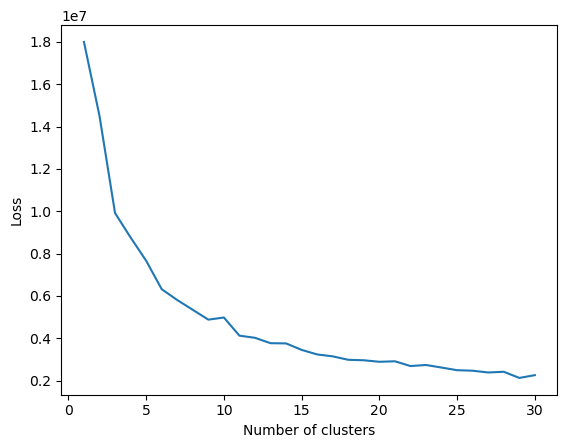

In [14]:
k_max = 30
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

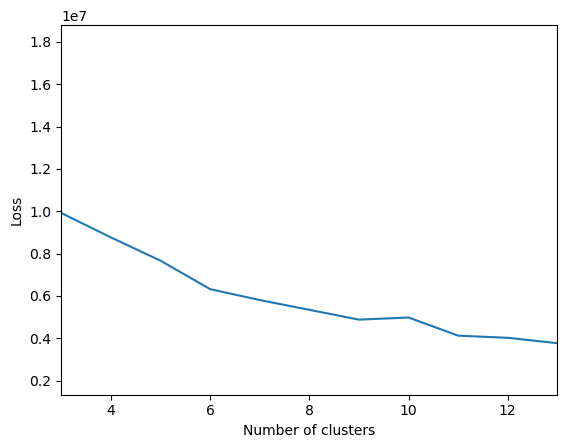

In [15]:
# zoom in
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([3,13])
plt.show()

A cluster number between 6 and 9 seems reasonable, we chose 6 clusters for the following analysis.

In [16]:
# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=6, random_state=42, init="k-means++")
means.fit(X_scaled)
cluster = ["1", "2", "3", "4", "5", "6"]
X_scaled_df["cluster"] = means.predict(X_scaled)
X_scaled_df["cluster"] = X_scaled_df["cluster"].apply(lambda x: cluster[x])

# add features for analysis
X_scaled_df["duration_per_trip"]= df_extra.trip_time_in_hours
X_scaled_df["hour"]=df_extra.hour
X_scaled_df["day_of_week"]=df_extra.day_of_week
X_scaled_df["user_type_unaltered"]=df.user_type

X_scaled_df.head()

,trip_time_in_hours,user_type,day_of_week,hour_sin,hour_cos,cluster,duration_per_trip,hour,user_type_unaltered
0,-0.399944,-0.480427,6,0.423764,2.450537,4,0.138611,0.066667,Subscriber
1,0.117325,-0.480427,6,0.435847,2.450184,4,0.340278,0.100000,Subscriber
2,-0.071485,2.081484,6,0.441888,2.449955,2,0.266667,0.116667,Customer
3,-0.446256,-0.480427,6,0.441888,2.449955,4,0.120556,0.116667,Subscriber
4,-0.250321,-0.480427,6,0.460005,2.449056,4,0.196944,0.166667,Subscriber


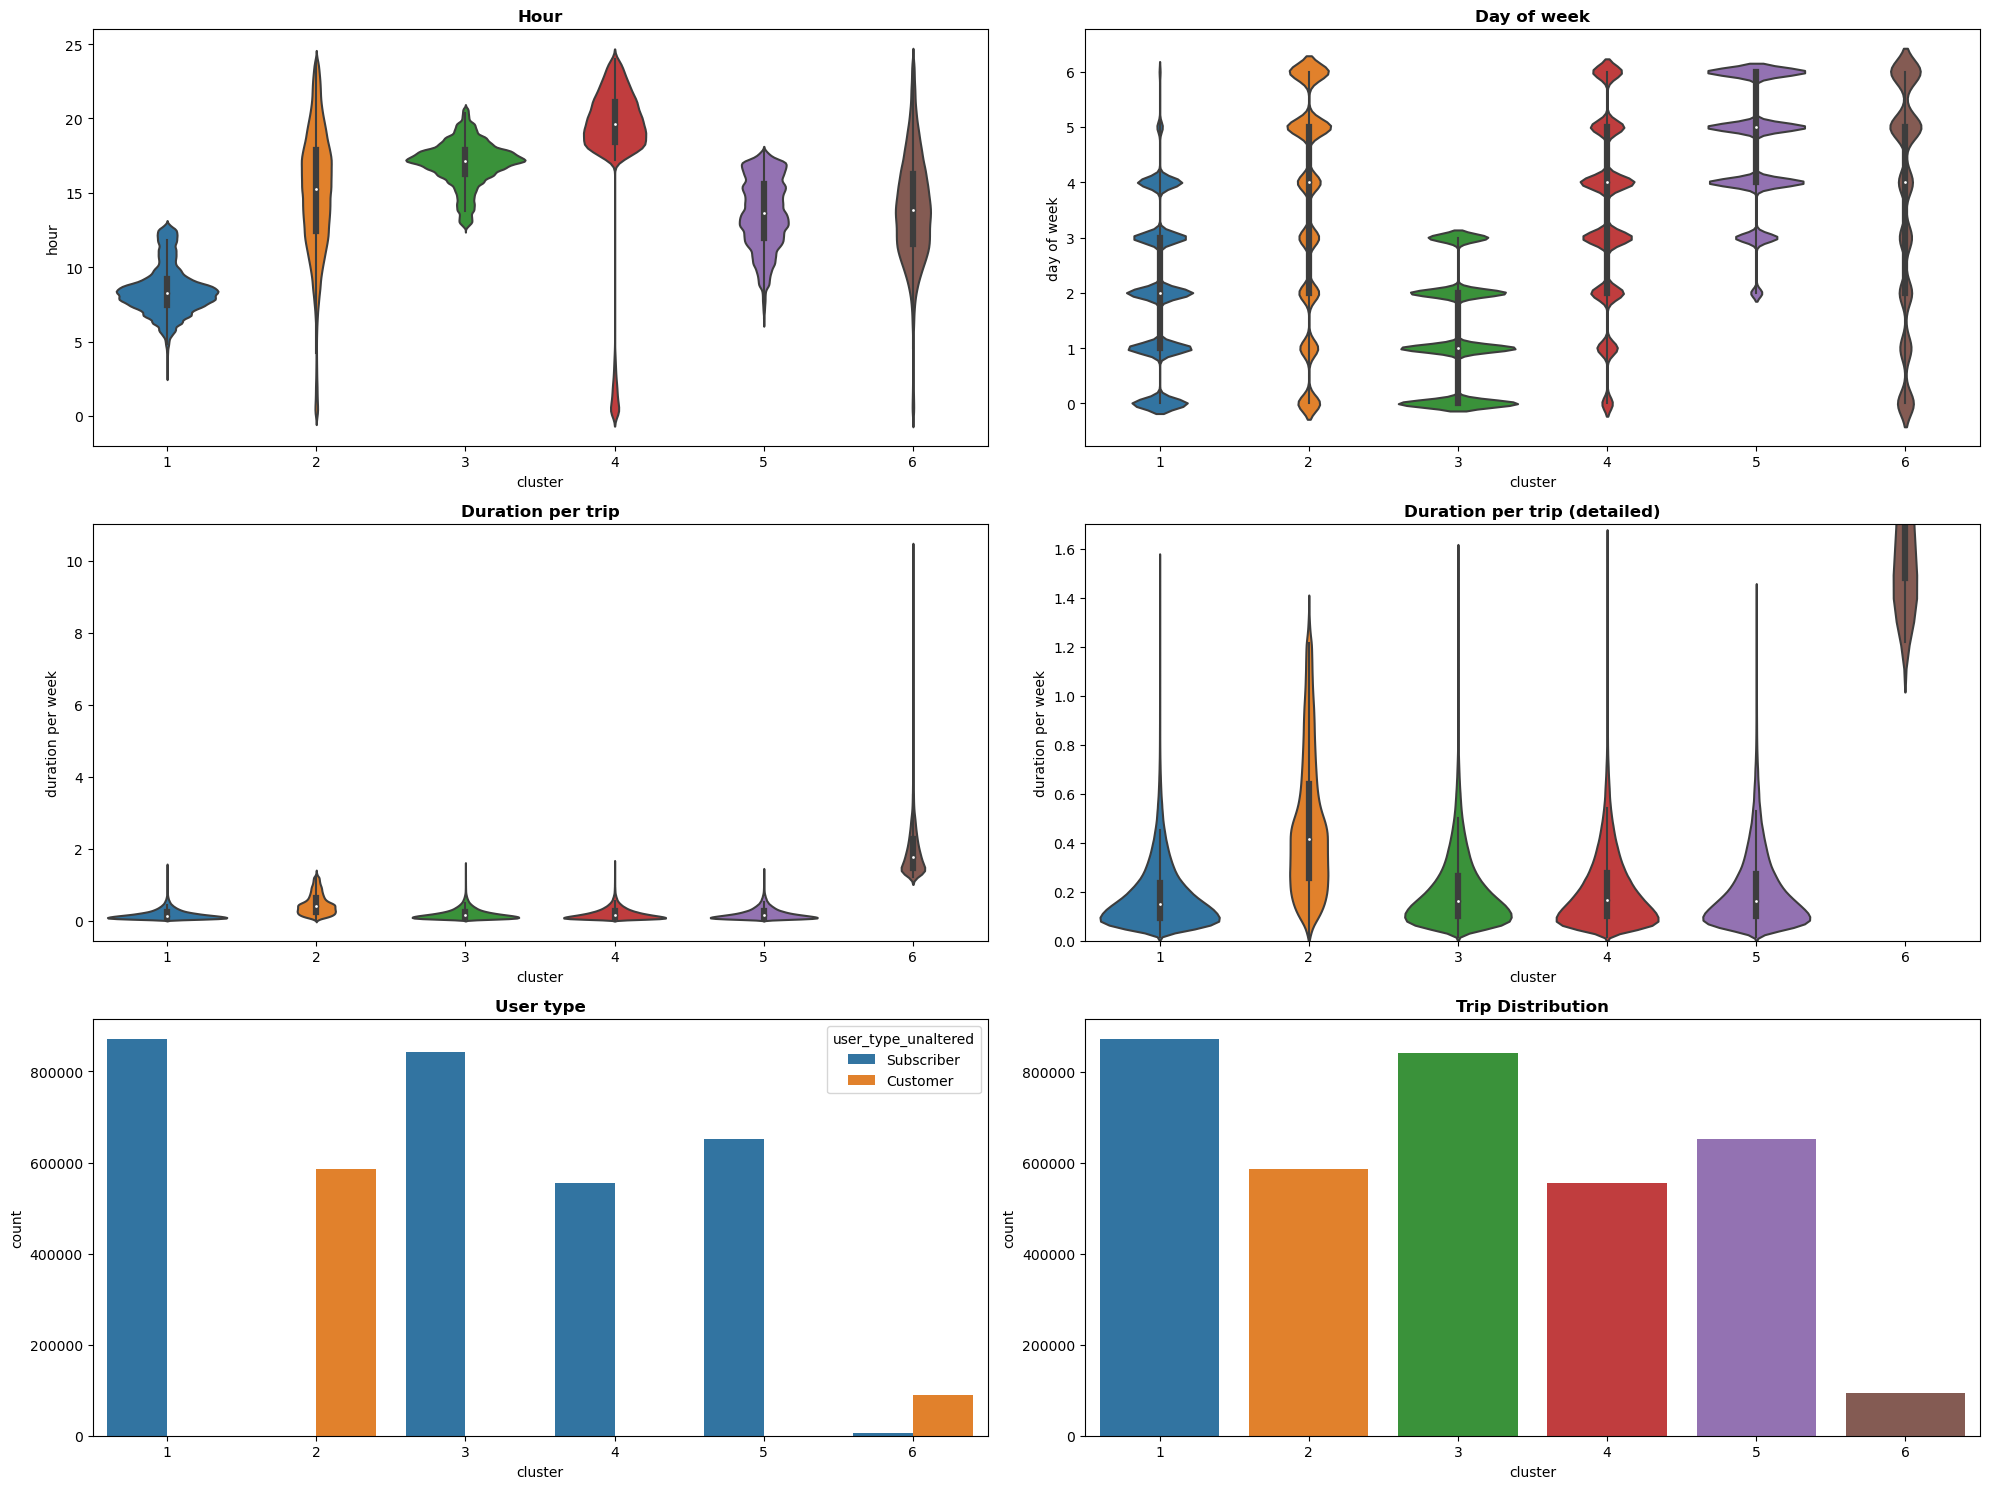

In [17]:
# visualize cluters regarding Hour, DayOfWeek, DurationPerTrip, DurationPerTripDetailed, UserType, TripDistribution
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=X_scaled_df['cluster'], y=X_scaled_df['hour'], data=X_scaled_df, order=['1','2','3','4','5','6'])
axes[0, 0].set_title('Hour', fontweight ='bold')

sns.violinplot(ax = axes[0, 1], x=X_scaled_df['cluster'], y=X_scaled_df['day_of_week'], data=X_scaled_df, order=['1','2','3','4','5','6'])
axes[0,1].set_ylabel('day of week')
axes[0, 1].set_title('Day of week', fontweight ='bold')

sns.violinplot(ax = axes[1, 0], x=X_scaled_df['cluster'], y=X_scaled_df['duration_per_trip'], data=X_scaled_df, order=['1','2','3','4','5','6'])
axes[1,0].set_ylabel('duration per week')
axes[1, 0].set_title('Duration per trip', fontweight ='bold')

sns.violinplot(ax = axes[1, 1], x=X_scaled_df['cluster'], y=X_scaled_df['duration_per_trip'], data=X_scaled_df, order=['1','2','3','4','5','6'])
axes[1, 1].set_ylim(0,1.7)
axes[1,1].set_ylabel('duration per week')
axes[1, 1].set_title('Duration per trip (detailed)', fontweight ='bold')

sns.countplot(ax = axes[2, 0], x =X_scaled_df['cluster'], hue = X_scaled_df['user_type_unaltered'], data = X_scaled_df, order=['1','2','3','4','5','6'])
axes[2, 0].set_title('User type', fontweight ='bold')

sns.countplot(ax = axes[2, 1], x =X_scaled_df['cluster'], data = X_scaled_df, order=['1','2','3','4','5','6'])
axes[2, 1].set_title('Trip Distribution', fontweight ='bold')

violin_plots.tight_layout()
plt.show()

For better understanding we visualized the different clusters regarding: hour, day of week (with Monday starting on 0), duration per trip, user type, trip distribution. For detailed view, we also zoomed in for the duration per trip.<br>
Now we can use these plots to describe and analyze the clusters and identify trip and customer types.

**Cluster 1**: short trips which are mainly in the early hours on weekdays of subscribers. The peak lies on about 8 hours. People cycle to work in the morning.<br>
**Cluster 2**: little bit longer trips during the whole day of customers, with slightly more distribution on the weekend. Spontaneous/unregular bike trips between about 20 minutes and 1 hour.<br>
**Cluster 3**: short trips in the afternoon on weekdays of subscribers. The peak lies on about 17 hours. People cycle home after work. The distribution of this cluster is as high as cluster 1, which also indicates that people cycle both to work and home.<br>
**Cluster 4**: short trips in the night over the whole week of subscribers. The highest distribution lies around Friday, so this cluster contains the trips of people after going out.<br>
**Cluster 5**: short trips at daytime mostly at the end of the week of subscribers. These are the trips in the free time of people.<br>
**Cluster 6**: very long trips during the whole day mostly of customers, with slightly more distribution on the weekend. Very low distribution overall. Spontaneous/unregular bike trips over 1 hour, the .<br>

All the clusters make sense and fulfill the expectations, so we see the number 6 for the clusters with the used features as fitting. The gained insights of this analysis can be used to adapt and improve the bike-rental-services.

### 3.2 Weather Trip Clustering

In the first analysis we clustered the trips, now we also want to take the weather into account. Once again, we determine the number of clusters as a first step.

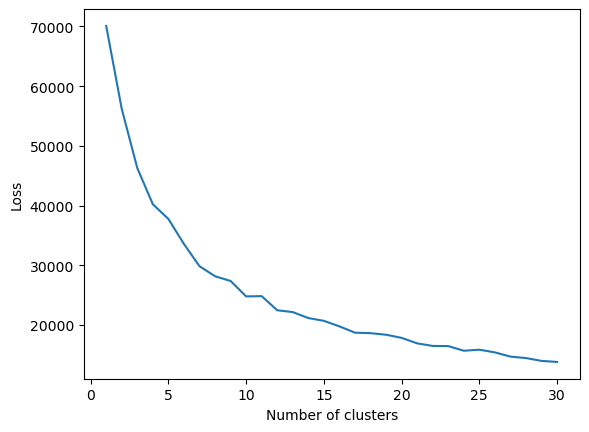

In [18]:
k_max = 30
clusters = []
losses = []

# search for clusters vs loss
# we use MiniBatchKMeans because of the huge dataset
# we experienced good results with random_state=42 
for k in range(k_max):
    model = MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_weather_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

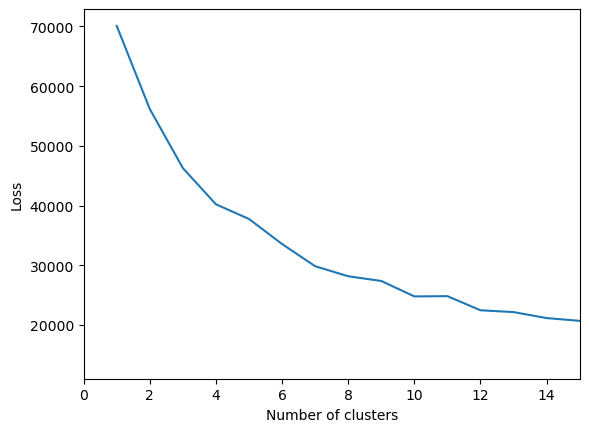

In [19]:
# zoom in
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,15])
plt.show()

With the elbow-methode we see 7 as a good number of clusters.

In [20]:
# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=7, random_state=42, init="k-means++")
means.fit(X_weather_scaled)
cluster = ["1", "2", "3", "4", "5","6","7"]
X_weather_scaled_df["cluster"] = means.predict(X_weather_scaled)
X_weather_scaled_df["cluster"] = X_weather_scaled_df["cluster"].apply(lambda x: cluster[x])

# get real features for analysis
df_weather["cluster"] = X_weather_scaled_df["cluster"]
df_weather["hour"] = df_weather.index.hour
df_weather["month"] = df_weather.index.month
df_weather["quarter"] = df_weather["month"].apply(lambda x: (x-1) // 3 + 1)

df_weather

,temp,precip,demand,day_of_week,hour_sin,hour_cos,quarter_sin,quarter_cos,cluster,hour,month,quarter
date_time,,,,,,,,,,,,
2018-01-01 00:00:00,-13.9,0.0,7,0,0.000000,1.000000,0.258819,0.965926,5,0,1,1
2018-01-01 01:00:00,-15.0,0.0,14,0,0.258819,0.965926,0.258819,0.965926,5,1,1,1
2018-01-01 02:00:00,-15.6,0.0,10,0,0.500000,0.866025,0.258819,0.965926,5,2,1,1
2018-01-01 03:00:00,-16.7,0.0,2,0,0.707107,0.707107,0.258819,0.965926,5,3,1,1
2018-01-01 04:00:00,-17.2,0.0,2,0,0.866025,0.500000,0.258819,0.965926,5,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,3.3,1.0,41,0,-0.965926,0.258819,0.866025,0.500000,7,19,12,4
2018-12-31 20:00:00,3.9,1.0,28,0,-0.866025,0.500000,0.866025,0.500000,7,20,12,4
2018-12-31 21:00:00,3.6,1.0,22,0,-0.707107,0.707107,0.866025,0.500000,7,21,12,4


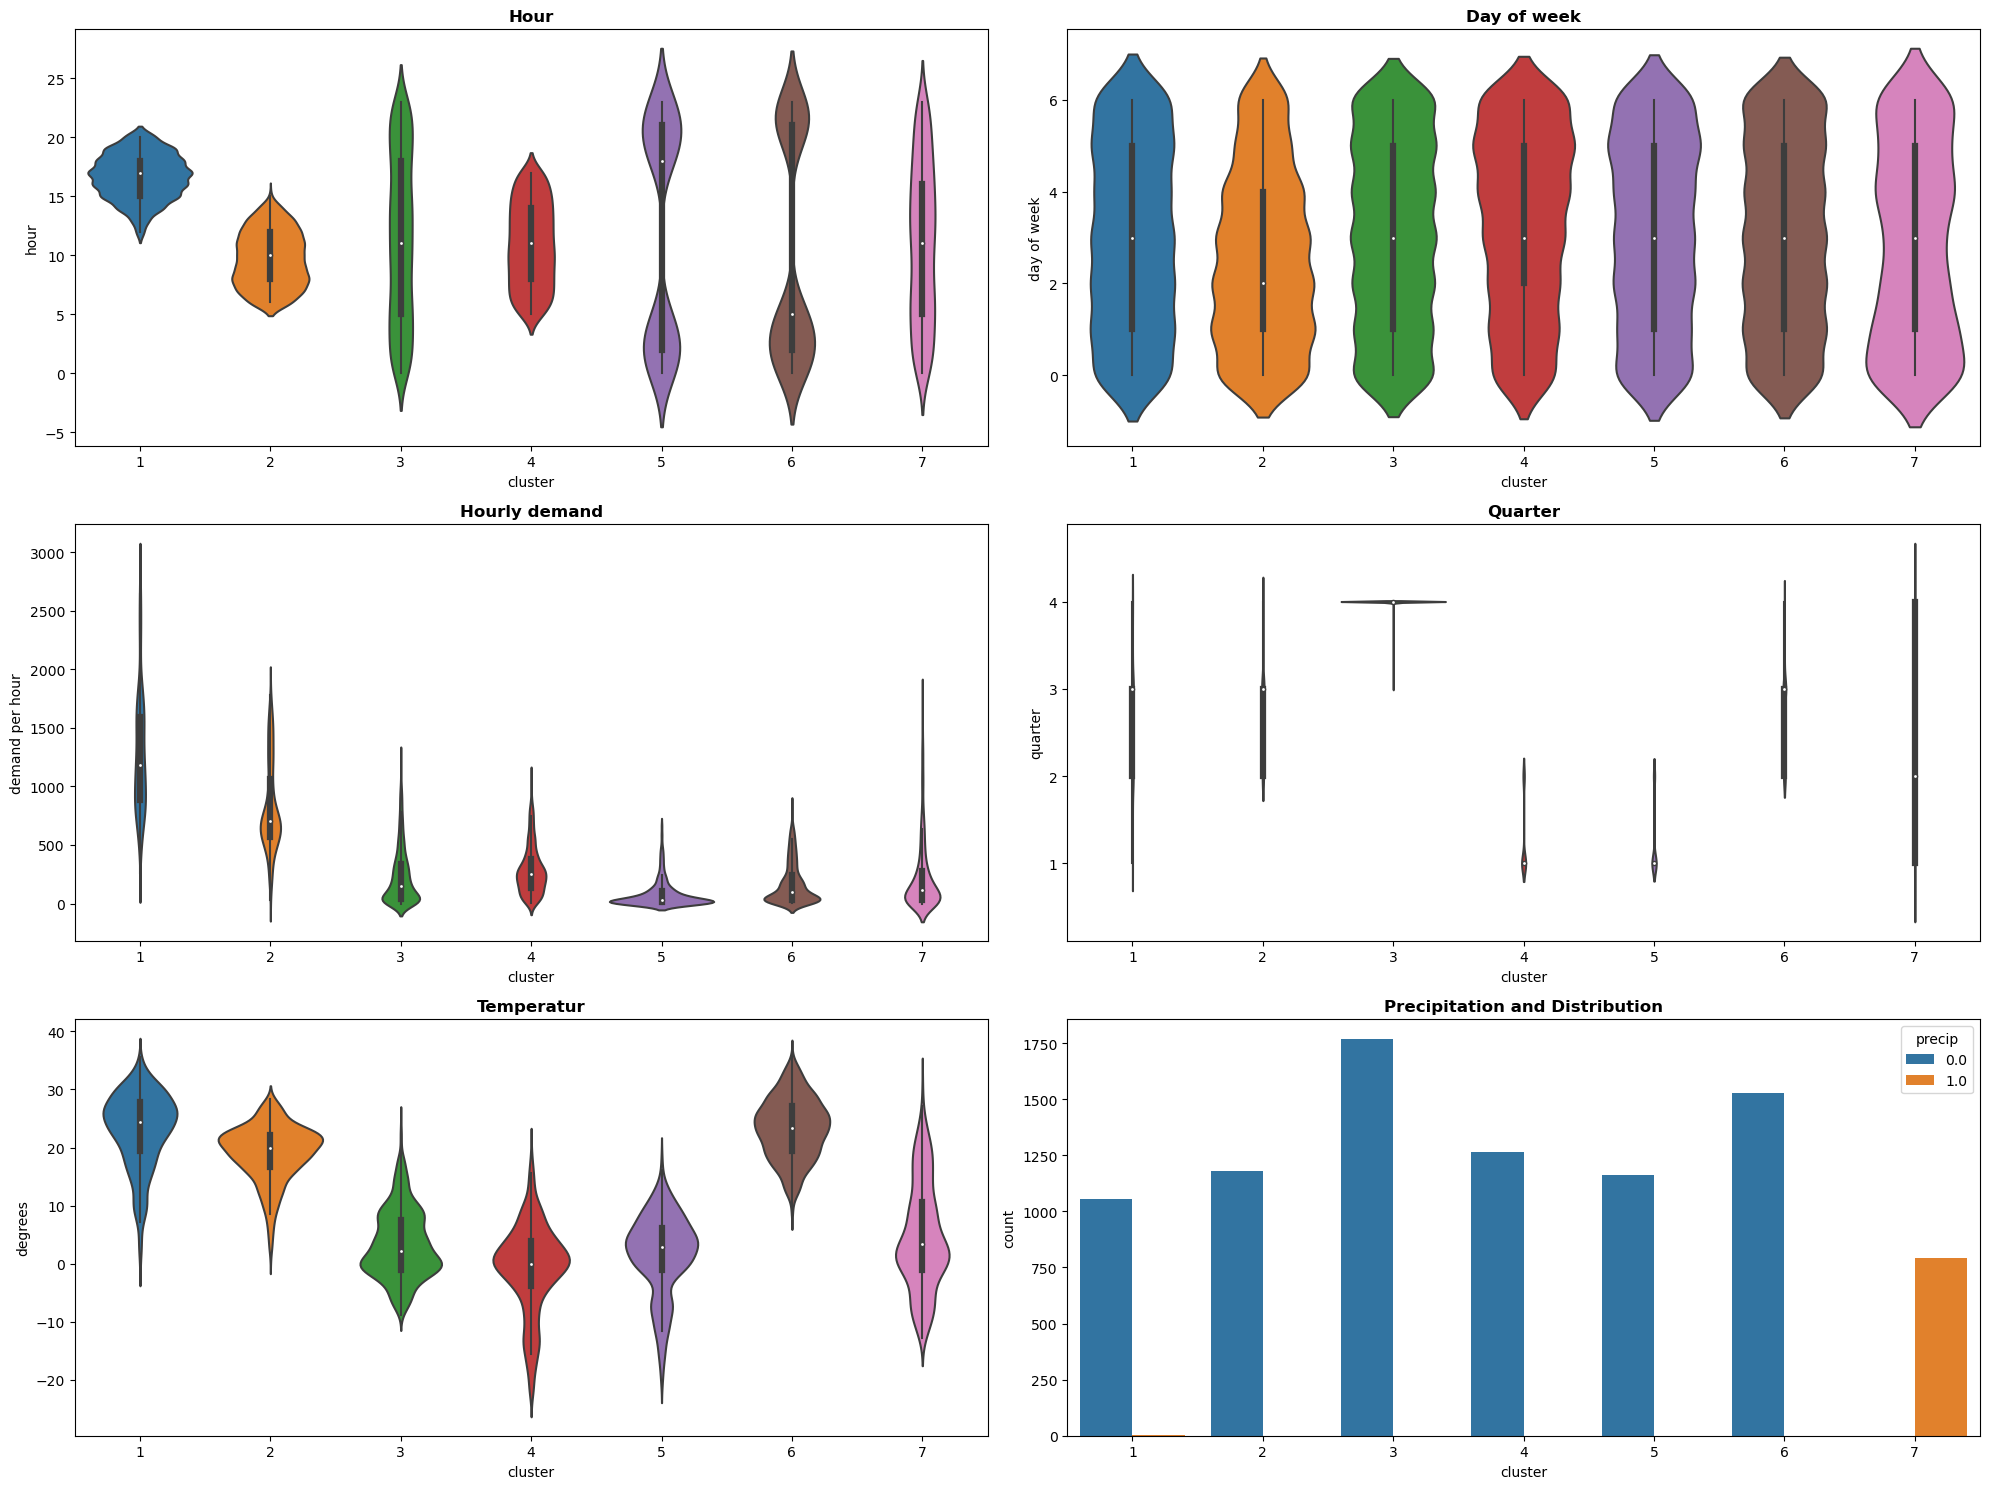

In [21]:
# visualize cluters regarding Hour, DayOfWeek, HourlyDemand, Quartner, Temperatur, Precip & TripDistribution
violin_plots,axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax= axes[0, 0], x=df_weather['cluster'], y=df_weather['hour'], data=df_weather,order=['1','2','3','4','5','6','7'])
axes[0,0].set_title('Hour', fontweight ='bold')

sns.violinplot(ax= axes[0, 1], x=df_weather['cluster'], y=df_weather['day_of_week'], data=df_weather,order=['1','2','3','4','5','6','7'])
axes[0,1].set_ylabel('day of week')
axes[0,1].set_title('Day of week', fontweight ='bold')

sns.violinplot(ax= axes[1, 0], x=df_weather['cluster'], y=df_weather['demand'], data=df_weather,order=['1','2','3','4','5','6','7'])
axes[1,0].set_ylabel('demand per hour')
axes[1,0].set_title('Hourly demand', fontweight ='bold')

sns.violinplot(ax= axes[1, 1], x=df_weather['cluster'], y=df_weather['quarter'], data=df_weather, order=['1','2','3','4','5',"6","7"])
axes[1,1].set_title('Quarter', fontweight ='bold')

sns.violinplot(ax= axes[2, 0], x =df_weather['cluster'], y=df_weather['temp'],data = df_weather, order=['1','2','3','4','5','6','7'])
axes[2,0].set_ylabel('degrees')
axes[2,0].set_title('Temperatur', fontweight ='bold')

sns.countplot(ax = axes[2, 1], x =df_weather['cluster'], hue = df_weather['precip'], data = df_weather, order=['1','2','3','4','5','6','7'])
axes[2, 1].set_title('Precipitation and Distribution', fontweight ='bold')

violin_plots.tight_layout()
plt.show()

This time we visualized the different clusters regarding: <br>
* hour
* day of week (with Monday starting with 0)
* hourly demand of trips
* quarter
* temperatur
* precipitation 
* distribution <br>

**Cluster 1**: trips in the afternoon, at the whole year but primarely in the second and third quarter, at high temperatures with no rain, high hourly demand. This cluster contains trips in hours where a lot of people want to bike because of good weather in their free time or back home after work.<br>
**Cluster 2**: trips in the morning, primerly in the second and third quarter of the year, with average temperatures at about 20 degrees and no rain, high hourly demand. This cluster is the partner of cluster 1, with the difference in the time. The colder temperatures could be explained by the earlier hours, as well as the little lower hourly demand because less people want to bicycle at those times.<br>
**Cluster 3**: trips at all hours, only in the last quarter of the year, colder temperatures and no rain. This cluster primarely contains trips in the winter with low hourly demand.<br>
**Cluster 4**: trips in the daytime, primarely in the first quarter of the year, cold to very cold temperatures and no rain, low hourly demand. Not a lot of people want to bicycle at cold temperatures.<br>
**Cluster 5**: trips in the nighttime, primarely in the first quarter of the year, cold to very cold temperatures and no rain, very low hourly demand. Not a lot of people want to bicycle at cold temperatures, especially at late hours.<br>
**Cluster 6**: trips in the nighttime, most in the second and third quarter of the year, warm temperatures and no rain, low hourly demand. Compared to cluster 5 a bit more people want to take trips at night due to higher temperatures.<br>
**Cluster 7**: trips at all hours, all year, medium temperatures, low hourly demand. That cluster contains all hours with trips that have precipitation.<br>

One interesting observation is that the feature "day of the week" does not have lots of differences thoughout the clusters. A slight tendency for weekdays can be seen for cluster 2, which makes sense, because people have to get to their workplaces on those days.<br>
There is no cluster, which does not make sense, so we see 7 as a good cluster number. Except for the day of weeks feature, the clusters differ greatly in the variables and can be analyzed well.

## 3.3 Station Clustering

In this section we want to find clusters for the stations of the trips.

In [22]:
# get Ids as index
X_station_scaled_trans = X_station_scaled.transpose()
X_station_scaled_trans

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
start_station_id,,,,,,,,,,,,,,,,,,,,,
2,-1.078134,-1.151940,-1.164241,-1.194994,-1.194994,-1.182693,-1.041231,-1.010478,-0.530738,-0.198610,...,0.988439,1.154503,1.634243,1.591189,1.289814,0.846977,0.810074,0.047410,-0.530738,-0.764458
3,-0.825195,-0.832895,-0.835975,-0.839055,-0.842135,-0.831355,-0.782074,-0.731254,-0.531051,-0.474070,...,1.617280,2.236368,2.225588,0.531564,-0.079824,-0.232287,-0.373969,-0.363188,-0.434029,-0.661953
4,-1.063548,-1.162636,-1.158673,-1.174527,-1.166600,-0.889152,-0.342185,-0.282732,-0.104373,-0.211388,...,0.295944,0.549610,1.227374,2.499668,1.881357,1.096577,0.434667,-0.472982,-0.746465,-1.043730
5,-1.164568,-1.217667,-1.246631,-1.222494,-1.256285,-1.121123,-0.614264,0.621505,2.060018,0.727704,...,0.032584,0.771149,1.181463,2.084154,1.128364,0.809767,0.056720,0.071202,-0.667364,-0.961824
6,-1.055921,-1.086601,-1.110464,-1.107055,-1.103646,-1.055921,-0.718435,-0.711617,-0.503672,-0.282090,...,0.992855,1.309887,1.306478,1.957587,1.647373,0.409926,-0.087780,-0.340042,-0.554806,-0.943426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,-0.759564,-0.759564,-0.915372,-0.603756,0.175284,-0.603756,-0.759564,-0.136332,3.914677,-0.447948,...,0.642708,-0.136332,-0.292140,-0.292140,0.798516,0.798516,-0.292140,-0.292140,-0.759564,0.019476
661,-0.604450,-0.604450,-0.604450,-0.604450,-0.604450,-0.604450,-0.604450,-0.604450,1.955575,-0.604450,...,1.102233,1.102233,1.955575,1.955575,1.955575,-0.604450,-0.604450,-0.604450,-0.604450,-0.604450
662,-0.627456,-0.627456,-0.627456,-0.627456,-0.627456,-0.627456,-0.627456,-0.250982,3.137279,-0.250982,...,-0.627456,-0.627456,-0.250982,0.125491,2.007859,-0.627456,-0.250982,0.501965,-0.627456,-0.627456


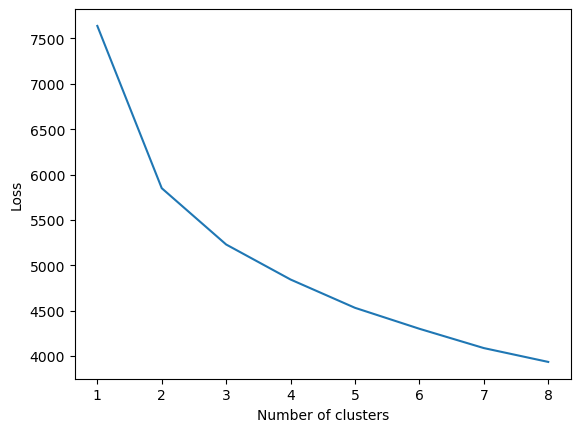

In [23]:
k_max = 8
clusters = []
losses = []

# search for clusters vs loss
# we experienced good results with random_state=42 
for k in range(k_max):
    model = KMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model.fit(X_station_scaled_trans)
    clusters.append(k+1)
    losses.append(model.inertia_)

# visualize
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

A good number for clusters seems to be between 2 or 3. We tried both and 2 makes much more sense for the analysis.

In [24]:
# apply K-Means with specific cluster number
means = MiniBatchKMeans(n_clusters=2, random_state=42, init="k-means++")
means.fit(X_station_scaled_trans)
cluster = ["1", "2"]
X_station_scaled_trans["cluster"] = means.predict(X_station_scaled_trans)
X_station_scaled_trans["cluster"] = X_station_scaled_trans["cluster"].apply(lambda x: cluster[x])

X_station_scaled_trans.head()

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
start_station_id,,,,,,,,,,,,,,,,,,,,,
2,-1.078134,-1.151940,-1.164241,-1.194994,-1.194994,-1.182693,-1.041231,-1.010478,-0.530738,-0.198610,...,1.154503,1.634243,1.591189,1.289814,0.846977,0.810074,0.047410,-0.530738,-0.764458,1
3,-0.825195,-0.832895,-0.835975,-0.839055,-0.842135,-0.831355,-0.782074,-0.731254,-0.531051,-0.474070,...,2.236368,2.225588,0.531564,-0.079824,-0.232287,-0.373969,-0.363188,-0.434029,-0.661953,1
4,-1.063548,-1.162636,-1.158673,-1.174527,-1.166600,-0.889152,-0.342185,-0.282732,-0.104373,-0.211388,...,0.549610,1.227374,2.499668,1.881357,1.096577,0.434667,-0.472982,-0.746465,-1.043730,1
5,-1.164568,-1.217667,-1.246631,-1.222494,-1.256285,-1.121123,-0.614264,0.621505,2.060018,0.727704,...,0.771149,1.181463,2.084154,1.128364,0.809767,0.056720,0.071202,-0.667364,-0.961824,1
6,-1.055921,-1.086601,-1.110464,-1.107055,-1.103646,-1.055921,-0.718435,-0.711617,-0.503672,-0.282090,...,1.309887,1.306478,1.957587,1.647373,0.409926,-0.087780,-0.340042,-0.554806,-0.943426,1


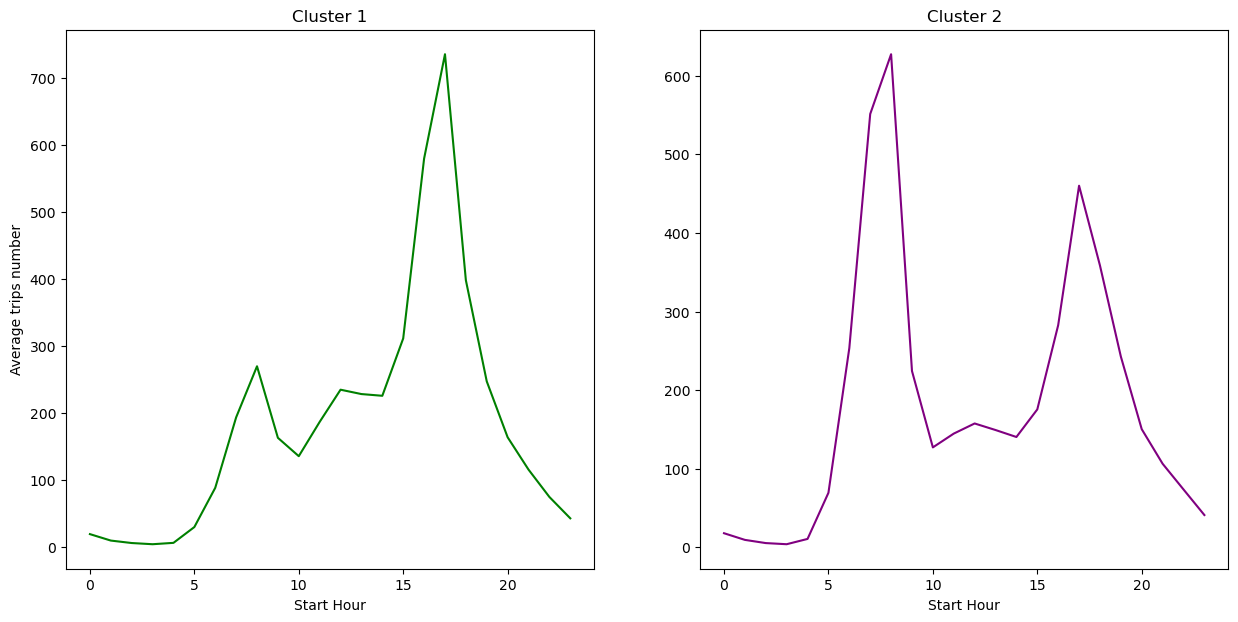

In [25]:
# transpose dataframe back
X_station_scaled = X_station_scaled_trans.transpose()

# bring cluster to unscaled data
df_station.loc["cluster"] = X_station_scaled.iloc[-1].apply(pd.to_numeric)

# select stations for every cluster
df_station_cluster_1 = df_station[df_station.columns[df_station.iloc[-1]==1]]
df_station_cluster_2 = df_station[df_station.columns[df_station.iloc[-1]==2]]

# remove last row with cluster
df_station_cluster_1 = df_station_cluster_1.drop(["cluster"])
df_station_cluster_2 = df_station_cluster_2.drop(["cluster"])

# calculate average
df_station_cluster_1["average"] = df_station_cluster_1.mean(axis=1)
df_station_cluster_2["average"] = df_station_cluster_2.mean(axis=1)

# plot all the normalised curves and the average for each cluster
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,7))

# plot cluster 1
df_station_cluster_1["average"].plot(ax=axes[0],color="green", alpha=1)
axes[0].set_title("Cluster 1")
axes[0].set_ylabel("Average trips number")
axes[0].set_xlabel("Start Hour")

# plot cluster 2 
df_station_cluster_2["average"].plot(ax=axes[1],color="purple", alpha=1)
axes[1].set_title("Cluster 2")
axes[1].set_xlabel("Start Hour")

plt.show()

We visualized both clusters regarding the start hour of the trip versus the average number of trips occuring at the stations which belong to the cluster. 

**Cluster 1**: there exists a slight peak at about 8 hours, but a huge peak with over 700 average trips at about 17 hours. These are station where people take bycicle after work to get home or go out again in the afternoon.<br>
**Cluster 2**: at 8 hours is a big peak with over 600 average trips, at 17 hours occurs a smaller peak with about 450 average trips. This cluster contains stations where people take bicycle in the morning to work as well as back home in the afternoon. 

To gain further insight on these clusters for the stations, we look at the station locations in the following.

In [26]:
def heat_map(df):
    # define new map
    heat_map = folium.Map(
        location=(41.9, -87.65), 
        tiles='OpenStreetMap', 
        zoom_start=11.5, 
        control_scale=True, 
        max_zoom=20)
    # add heat map
    
    tuple = df["position"].dropna().apply(lambda x : make_tuple(x))
    heat_map.add_child(plugins.HeatMap(tuple, radius=15))
    
    return heat_map

Make sure to trust the notebook in order to see the maps.

In [27]:
# visualize station location of cluster 1 at 17 hours
station_cluster_1_location = df_station_cluster_1.transpose()
# drop average calculation
station_cluster_1_location.drop(station_cluster_1_location.tail(1).index,inplace=True)
station_cluster_1_location = station_cluster_1_location.sort_values(17,ascending=False)
station_cluster_1_location["position"] = stations["position"]

map = heat_map(station_cluster_1_location.head(100))
map

The above heatmap shows for **cluster 1** at 17 hours the 100 most used stations. It can be seen, that most of the stations are at the center of Chicago, especially in an area called Loop, where a lot of shops and offices are located. People rent bikes to get home, get to the next train station if they live further away, or make a trip for going out in the evenings.

In [28]:
# visualize station location of cluster 2 at 8 hours
station_cluster_2_location = df_station_cluster_2.transpose()
# drop average calculation
station_cluster_2_location.drop(station_cluster_2_location.tail(1).index,inplace=True)
station_cluster_2_location = station_cluster_2_location.sort_values(8,ascending=False)
station_cluster_2_location["position"] = stations["position"]

map = heat_map(station_cluster_2_location.head(100))
map

The above heatmap shows for **cluster 2** at 8 hours the 100 most used stations. It is visible, that it contains way more stations away from the center compared to cluster 1. A lot of trips start from the north, which is more a living area in Chicago. People take bicycle there to get to work in the morning. Also noticable is one peak area in the middle of the map and two smaller peaks north and south from it. Those **peaks** are in **areas around train stations** like: <br> 
* Oglivie Transportation Center
* Clark Devision
* LaSalle Street Station
<br>
<br>

This shows that people take trains from further away to get downtown and rent bicycles to get to their workplace in the end.

In [29]:
# visualize station location of cluster 2 at 17 hours
station_cluster_2_location_2 = station_cluster_2_location.sort_values(17,ascending=False)

map = heat_map(station_cluster_2_location_2.head(80))
map

The above heatmap shows for **cluster 2** at 17 hours the 80 most used stations. It is very similar to the heatmap at 8 hours before. People take a train to train stations in the afternoon and rent a bicycle to either get home, or do evening activities.